In [1]:
from pyscf import gto, scf
#import os
import numpy as np
from matplotlib import pyplot as plt

In [19]:
basis = 'sto6g'

d1 = 3
atom1 = f'''
H 0 0 0
H 0.74 0 0
H 0 {d1} 0
H 0.74 {d1} 0
'''

mol1 = gto.Mole(
verbose=3,
atom=atom1,
basis=basis,
)

mol1.build()
mf1 = scf.RHF(mol1)
mf1.kernel()

d2 = 4
atom2 = f'''
H 0 0 0
H 0.74 0 0
H 0 {d2} 0
H 0.74 {d2} 0
'''

mol2 = gto.Mole(
verbose=3,
atom=atom2,
basis=basis,
)

mol2.build()
mf2 = scf.RHF(mol2)
mf2.kernel()

print('the rhf energy difference is: ',mf1.e_tot-mf2.e_tot)

converged SCF energy = -2.25028565259931
converged SCF energy = -2.25072616899182
the rhf energy difference is:  0.00044051639250142216


In [21]:
#import struct
import time
#from functools import partial
from typing import List, Optional, Tuple, Union

#import h5py
import jax
import jax.numpy as jnp
from jax import random, lax
import numpy as np
#import scipy
from pyscf import __config__,  df,  lib, mcscf, scf
from pyscf.cc.ccsd import CCSD
from pyscf.cc.uccsd import UCCSD
from ad_afqmc import pyscf_interface, driver, mpi_jax


from ad_afqmc.propagation import propagator
from ad_afqmc.wavefunctions import wave_function
from ad_afqmc import sampling

modified_cholesky = pyscf_interface.modified_cholesky
generate_integrals = pyscf_interface.generate_integrals
ao2mo_chol_copy = pyscf_interface.ao2mo_chol_copy
ao2mo_chol = pyscf_interface.ao2mo_chol
write_dqmc = pyscf_interface.write_dqmc

def fix_len_chunked_cholesky(mol, chol_len, max_error=1e-6, verbose=False, cmax=10):
    """Modified cholesky decomposition of certain length from pyscf eris."""

    nao = mol.nao_nr()
    diag = np.zeros(nao * nao)
    nchol_max = cmax * nao
    # This shape is more convenient for pauxy.
    chol_vecs = np.zeros((nchol_max, nao * nao))
    ndiag = 0
    dims = [0]
    nao_per_i = 0
    for i in range(0, mol.nbas):
        l = mol.bas_angular(i)
        nc = mol.bas_nctr(i)
        nao_per_i += (2 * l + 1) * nc
        dims.append(nao_per_i)
    # print (dims)
    for i in range(0, mol.nbas):
        shls = (i, i + 1, 0, mol.nbas, i, i + 1, 0, mol.nbas)
        buf = mol.intor("int2e_sph", shls_slice=shls)
        di, dk, dj, dl = buf.shape
        diag[ndiag : ndiag + di * nao] = buf.reshape(di * nao, di * nao).diagonal()
        ndiag += di * nao
    nu = np.argmax(diag)
    delta_max = diag[nu]
    if verbose:
        print("# Generating Cholesky decomposition of ERIs." % nchol_max)
        print("# max number of cholesky vectors = %d" % nchol_max)
        print("# iteration %5d: delta_max = %f" % (0, delta_max))
    j = nu // nao
    l = nu % nao
    sj = np.searchsorted(dims, j)
    sl = np.searchsorted(dims, l)
    if dims[sj] != j and j != 0:
        sj -= 1
    if dims[sl] != l and l != 0:
        sl -= 1
    Mapprox = np.zeros(nao * nao)
    # ERI[:,jl]
    eri_col = mol.intor(
        "int2e_sph", shls_slice=(0, mol.nbas, 0, mol.nbas, sj, sj + 1, sl, sl + 1)
    )
    cj, cl = max(j - dims[sj], 0), max(l - dims[sl], 0)
    chol_vecs[0] = np.copy(eri_col[:, :, cj, cl].reshape(nao * nao)) / delta_max**0.5

    nchol = 0
    while abs(delta_max) > max_error:
        # Update cholesky vector
        start = time.time()
        # M'_ii = L_i^x L_i^x
        Mapprox += chol_vecs[nchol] * chol_vecs[nchol]
        # D_ii = M_ii - M'_ii
        delta = diag - Mapprox
        nu = np.argmax(np.abs(delta))
        delta_max = np.abs(delta[nu])
        # Compute ERI chunk.
        # shls_slice computes shells of integrals as determined by the angular
        # momentum of the basis function and the number of contraction
        # coefficients. Need to search for AO index within this shell indexing
        # scheme.
        # AO index.
        j = nu // nao
        l = nu % nao
        # Associated shell index.
        sj = np.searchsorted(dims, j)
        sl = np.searchsorted(dims, l)
        if dims[sj] != j and j != 0:
            sj -= 1
        if dims[sl] != l and l != 0:
            sl -= 1
        # Compute ERI chunk.
        eri_col = mol.intor(
            "int2e_sph", shls_slice=(0, mol.nbas, 0, mol.nbas, sj, sj + 1, sl, sl + 1)
        )
        # Select correct ERI chunk from shell.
        cj, cl = max(j - dims[sj], 0), max(l - dims[sl], 0)
        Munu0 = eri_col[:, :, cj, cl].reshape(nao * nao)
        # Updated residual = \sum_x L_i^x L_nu^x
        R = np.dot(chol_vecs[: nchol + 1, nu], chol_vecs[: nchol + 1, :])
        chol_vecs[nchol + 1] = (Munu0 - R) / (delta_max) ** 0.5
        nchol += 1
        if verbose:
            step_time = time.time() - start
            info = (nchol, delta_max, step_time)
            print("# iteration %5d: delta_max = %13.8e: time = %13.8e" % info)

    if chol_len > nchol:
        raise ValueError(f"given cholesky vector length {chol_len} exceeded the \n"
                         f"decompostion {nchol} lower chol_len or higher the chol_cut")

    return chol_vecs[:chol_len]

def fix_len_generate_integrals(mol, hcore, X, chol_len, chol_cut=1e-6, verbose=False, DFbas=None):
    # Unpack SCF data.
    # Step 1. Rotate core Hamiltonian to orthogonal basis.
    if verbose:
        print(" # Transforming hcore and eri to ortho AO basis.")
    if len(X.shape) == 2:
        h1e = np.dot(X.T, np.dot(hcore, X))
    elif len(X.shape) == 3:
        h1e = np.dot(X[0].T, np.dot(hcore, X[0]))

    if DFbas is not None:
        chol_vecs = df.incore.cholesky_eri(mol, auxbasis=DFbas)
        chol_vecs = lib.unpack_tril(chol_vecs).reshape(chol_vecs.shape[0], -1)
    else:  # do cholesky
        # nbasis = h1e.shape[-1]
        # Step 2. Genrate Cholesky decomposed ERIs in non-orthogonal AO basis.
        if verbose:
            print(" # Performing modified Cholesky decomposition on ERI tensor.")
        chol_vecs = fix_len_chunked_cholesky(mol,chol_len,max_error=chol_cut,verbose=verbose)

    if verbose:
        print(" # Orthogonalising Cholesky vectors.")
    start = time.time()

    # Step 2.a Orthogonalise Cholesky vectors.
    if len(X.shape) == 2 and X.shape[0] != X.shape[1]:
        chol_vecs = ao2mo_chol_copy(chol_vecs, X)
    elif len(X.shape) == 2:
        ao2mo_chol(chol_vecs, X)
    elif len(X.shape) == 3:
        ao2mo_chol(chol_vecs, X[0])
    if verbose:
        print(" # Time to orthogonalise: %f" % (time.time() - start))
    enuc = mol.energy_nuc()
    # Step 3. (Optionally) freeze core / virtuals.
    nelec = mol.nelec
    return h1e, chol_vecs, nelec, enuc

def fix_len_chol_prep(
    mf_or_cc: Union[scf.uhf.UHF, scf.rhf.RHF, CCSD, UCCSD],
    chol_len,
    basis_coeff: Optional[np.ndarray] = None,
    norb_frozen: int = 0,
    chol_cut: float = 1e-7,
    mo_file = "mo_coeff.npz",
    chol_file = "FCIDUMP_chol"
):
    
    mf = mf_or_cc
    mol = mf.mol

    if basis_coeff is None:
        if isinstance(mf, scf.uhf.UHF):
            basis_coeff = mf.mo_coeff[0]
        else:
            basis_coeff = mf.mo_coeff
            
    print("# Calculating Cholesky integrals")

    h1e, chol, nelec, enuc, nbasis,_ = [None] * 6

    h1e, chol, nelec, enuc = fix_len_generate_integrals(mol, mf.get_hcore(), basis_coeff, chol_len, chol_cut)
    nbasis = h1e.shape[-1]
    nelec = mol.nelec

    if norb_frozen > 0:
        assert norb_frozen * 2 < sum(
            nelec
        ), "Frozen orbitals exceed number of electrons"
        mc = mcscf.CASSCF(
            mf, mol.nao - norb_frozen, mol.nelectron - 2 * norb_frozen
        )
        nelec = mc.nelecas  # type: ignore
        mc.mo_coeff = basis_coeff  # type: ignore
        h1e, enuc = mc.get_h1eff()  # type: ignore
        chol = chol.reshape((-1, nbasis, nbasis))
        chol = chol[:, mc.ncore : mc.ncore + mc.ncas, mc.ncore : mc.ncore + mc.ncas]  # type: ignore

    print("# Finished calculating Cholesky integrals\n#")

    nbasis = h1e.shape[-1]
    print("# Size of the correlation space:")
    print(f"# Number of electrons: {nelec}")
    print(f"# Number of basis functions: {nbasis}")
    print(f"# Number of Cholesky vectors: {chol.shape[0]}\n#")
    chol = chol.reshape((-1, nbasis, nbasis))
    v0 = 0.5 * np.einsum("nik,njk->ij", chol, chol, optimize="optimal")
    h1e_mod = h1e - v0
    chol = chol.reshape((chol.shape[0], -1))

    # write trial mo coefficients
    trial_coeffs = np.empty((2, nbasis, nbasis))
    overlap = mf.get_ovlp(mol)
    if isinstance(mf, (scf.uhf.UHF, scf.rohf.ROHF)):
        uhfCoeffs = np.empty((nbasis, 2 * nbasis))
        if isinstance(mf, scf.uhf.UHF):
            q, r = np.linalg.qr(
                basis_coeff[:, norb_frozen:]
                .T.dot(overlap)
                .dot(mf.mo_coeff[0][:, norb_frozen:])
            )
            sgn = np.sign(r.diagonal())
            q = np.einsum("ij,j->ij", q, sgn)
            # q2 = basis_coeff[:, norb_frozen:].T.dot(overlap).dot(mf.mo_coeff[0][:, norb_frozen:])
            # print("max err a", np.max(abs(q-q2)))
            # q, _ = np.linalg.qr(
            #    basis_coeff[:, norb_frozen:]
            #    .T.dot(overlap)
            #    .dot(mf.mo_coeff[0][:, norb_frozen:])
            # )
            uhfCoeffs[:, :nbasis] = q
            q, r = np.linalg.qr(
                basis_coeff[:, norb_frozen:]
                .T.dot(overlap)
                .dot(mf.mo_coeff[1][:, norb_frozen:])
            )
            sgn = np.sign(r.diagonal())
            q = np.einsum("ij,j->ij", q, sgn)
            # q2 = basis_coeff[:, norb_frozen:].T.dot(overlap).dot(mf.mo_coeff[1][:, norb_frozen:])
            # print("max err b", np.max(abs(q-q2)))
            # import pdb
            # pdb.set_trace()
            # q, _ = np.linalg.qr(
            #     basis_coeff[:, norb_frozen:]
            #     .T.dot(overlap)
            #     .dot(mf.mo_coeff[1][:, norb_frozen:])
            # )
            uhfCoeffs[:, nbasis:] = q
        else:
            q, r = np.linalg.qr(
                basis_coeff[:, norb_frozen:]
                .T.dot(overlap)
                .dot(mf.mo_coeff[:, norb_frozen:])
            )
            sgn = np.sign(r.diagonal())
            q = np.einsum("ij,j->ij", q, sgn)
            uhfCoeffs[:, :nbasis] = q
            uhfCoeffs[:, nbasis:] = q

        trial_coeffs[0] = uhfCoeffs[:, :nbasis]
        trial_coeffs[1] = uhfCoeffs[:, nbasis:]
        # np.savetxt("uhf.txt", uhfCoeffs)
        np.savez(mo_file, mo_coeff=trial_coeffs)

    elif isinstance(mf, scf.rhf.RHF):
        q, _ = np.linalg.qr(
            basis_coeff[:, norb_frozen:]
            .T.dot(overlap)
            .dot(mf.mo_coeff[:, norb_frozen:])
        )
        trial_coeffs[0] = q
        trial_coeffs[1] = q
        np.savez(mo_file, mo_coeff=trial_coeffs)

    write_dqmc(
        h1e,
        h1e_mod,
        chol,
        sum(nelec),
        nbasis,
        enuc,
        ms=mol.spin,
        filename=chol_file,
        mo_coeffs=trial_coeffs,
    )


sampler_eq = sampling.sampler(n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10)

def init_prop(ham_data, ham, prop, trial, wave_data, options, MPI):
    comm = MPI.COMM_WORLD
    #size = comm.Get_size()
    rank = comm.Get_rank()
    seed = options["seed"]
    #neql = options["n_eql"]
    init_walkers: Optional[Union[List, jax.Array]] = None
    trial_rdm1 = trial.get_rdm1(wave_data)
    if "rdm1" not in wave_data:
        wave_data["rdm1"] = trial_rdm1
    ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
    ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)
    prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
    prop_data["key"] = random.PRNGKey(seed + rank)
    prop_data["n_killed_walkers"] = 0
    print(f"# initial energy: {prop_data['e_estimate']:.9e}")
    
    return prop_data, ham_data

def en_samples(prop_data,ham_data,prop,trial,wave_data):
    energy_samples = jnp.real(
        trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    )
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]) > jnp.sqrt(2.0 / prop.dt),
        prop_data["e_estimate"],
        energy_samples,
    )
    return energy_samples

def block_en_weight(prop_data,ham_data,prop,trial,wave_data):

    energy_samples = en_samples(prop_data,ham_data,prop,wave_data,trial)

    block_weight = jnp.sum(prop_data["weights"])
    block_energy = jnp.sum(energy_samples * prop_data["weights"]) / block_weight
    return block_energy, block_weight

def field_block_scan(
        prop_data: dict,
        fields,
        ham_data: dict,
        prop: propagator,
        trial: wave_function,
        wave_data: dict,
        ) -> Tuple[dict, Tuple[jax.Array, jax.Array]]:
    """Block scan function for a given field"""
    _step_scan_wrapper = lambda x, y: sampler_eq._step_scan(
        x, y, ham_data, prop, trial, wave_data
    )
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)
    prop_data["n_killed_walkers"] += prop_data["weights"].size - jnp.count_nonzero(
        prop_data["weights"]
    )
    prop_data = prop.orthonormalize_walkers(prop_data)
    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)

    block_energy,_ = block_en_weight(prop_data,ham_data,prop,wave_data,trial)
    prop_data["pop_control_ene_shift"] = (
        0.9 * prop_data["pop_control_ene_shift"] + 0.1 * block_energy
    )
    return prop_data

def cs_block_scan(
        prop_data1: dict,
        ham_data1: dict,
        prop1: propagator,
        trial1: wave_function,
        wave_data1: dict,
        prop_data2: dict,
        ham_data2: dict,
        prop2: propagator,
        trial2: wave_function,
        wave_data2: dict):
    '''correlated sampling of two blocks over the same field'''
    prop_data1["key"], subkey1 = random.split(prop_data1["key"])
    fields = random.normal(
        subkey1,
        shape=(
            sampler_eq.n_prop_steps,
            prop1.n_walkers,
            ham_data1["chol"].shape[0],
        )
    )
    prop_data1 = field_block_scan(prop_data1,fields,ham_data1,prop1,trial1,wave_data1)
    prop_data2 = field_block_scan(prop_data2,fields,ham_data2,prop2,trial2,wave_data2)

    return prop_data1, prop_data2, fields

def ucs_block_scan(
        prop_data1: dict,
        ham_data1: dict,
        prop1: propagator,
        trial1: wave_function,
        wave_data1: dict,
        prop_data2: dict,
        ham_data2: dict,
        prop2: propagator,
        trial2: wave_function,
        wave_data2: dict):
    '''correlated sampling of two blocks over the same field'''
    prop_data1["key"], subkey1 = random.split(prop_data1["key"])
    fields1 = random.normal(
        subkey1,
        shape=(
            sampler_eq.n_prop_steps,
            prop1.n_walkers,
            ham_data1["chol"].shape[0],
        )
    )
    prop_data1 = field_block_scan(prop_data1,fields1,ham_data1,prop1,trial1,wave_data1)

    prop_data2["key"], subkey2 = random.split(prop_data2["key"])
    fields2 = random.normal(
        subkey2,
        shape=(
            sampler_eq.n_prop_steps,
            prop2.n_walkers,
            ham_data2["chol"].shape[0],
        )
    )
    prop_data2 = field_block_scan(prop_data2,fields2,ham_data2,prop2,trial2,wave_data2)

    return prop_data1, prop_data2, fields1, fields2

In [22]:
mo_file1="mo1.npz"
amp_file1="amp1.npz"
chol_file1="chol1"
pyscf_interface.prep_afqmc(mf1,chol_cut=1e-6,mo_file=mo_file1,chol_file=chol_file1)

#
# Preparing AFQMC calculation
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (2, 2)
# Number of basis functions: 4
# Number of Cholesky vectors: 8
#


In [23]:
mo_file1="mo1.npz"
amp_file1="amp1.npz"
chol_file1="chol1"
fix_len_chol_prep(mf1,chol_len=8,chol_cut=1e-6,mo_file=mo_file1,chol_file=chol_file1)
mo_file2="mo2.npz"
amp_file2="amp2.npz"
chol_file2="chol2"
fix_len_chol_prep(mf2,chol_len=8,chol_cut=1e-7,mo_file=mo_file2,chol_file=chol_file2)

# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (2, 2)
# Number of basis functions: 4
# Number of Cholesky vectors: 8
#
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (2, 2)
# Number of basis functions: 4
# Number of Cholesky vectors: 8
#


In [24]:
options1 = {
    "dt": 0.005,
    "n_eql": 4,
    "n_ene_blocks": 1,
    "n_sr_blocks": 10,
    "n_blocks": 200,
    "n_walkers": 100,
    "seed": 98,
    "walker_type": "rhf",
    "trial": "rhf",
}

options2 = {
    "dt": 0.005,
    "n_eql": 4,
    "n_ene_blocks": 1,
    "n_sr_blocks": 10,
    "n_blocks": 200,
    "n_walkers": 100,
    "seed": 2,
    "walker_type": "rhf",
    "trial": "rhf",
}

In [25]:
afqmc1 = (mpi_jax._prep_afqmc(options1,mo_file=mo_file1,amp_file=amp_file1,chol_file=chol_file1))
e_afqmc1, err_afqmc1 = driver.afqmc(*afqmc1)

# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# dt: 0.005
# n_eql: 4
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 200
# n_walkers: 100
# seed: 98
# walker_type: rhf
# trial: rhf
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Equilibration sweeps:
#   Iter        Block energy      Walltime
#     0      -2.250285482e+00     9.27e-01 
#     1      -2.288840771e+00     3.62e+00 
#     2      -2.286935568e+00     6.34e+00 
#     3      -2.292957067e+00     7.13e+00 
#     4      -2.291953325e+00     7.98e+00 
#
# Sampling sweeps:
#  Iter        Mean energy          Stochastic error       Walltime
     0      -2.295662165e+00                -              1.02e+01 
    20      -2.292462586e+00        2.863062183e-03        1.41e+01 
    40      -2.291871794e+00        1.432505255e-03        1.77e+01 
    60      -2.291171021e+00        

In [26]:
afqmc2 = (mpi_jax._prep_afqmc(options2,mo_file=mo_file2,amp_file=amp_file2,chol_file=chol_file2))
e_afqmc2, err_afqmc2 = driver.afqmc(*afqmc2)

# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# dt: 0.005
# n_eql: 4
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 200
# n_walkers: 100
# seed: 2
# walker_type: rhf
# trial: rhf
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Equilibration sweeps:
#   Iter        Block energy      Walltime
#     0      -2.250726166e+00     4.95e-01 
#     1      -2.291447163e+00     1.40e+00 
#     2      -2.289932489e+00     2.38e+00 
#     3      -2.291737318e+00     3.30e+00 
#     4      -2.291962147e+00     4.27e+00 
#
# Sampling sweeps:
#  Iter        Mean energy          Stochastic error       Walltime
     0      -2.288145065e+00                -              4.47e+00 
    20      -2.292703029e+00                -              8.35e+00 
    40      -2.291847241e+00        1.379046113e-03        1.24e+01 
    60      -2.291695501e+00        5

In [27]:
afqmc_en_diff = e_afqmc1 - e_afqmc2
afqmc_en_diff_err = np.sqrt(err_afqmc1**2+err_afqmc2**2)
print(f'the afqmc energy difference is {afqmc_en_diff}, error is {afqmc_en_diff_err}')

the afqmc energy difference is 0.00043072147302902763, error is 0.0005473235626514408


In [28]:
ham_data1, ham1, prop1, trial1, wave_data1, sampler1, observable1, options1, MPI \
    = mpi_jax._prep_afqmc(options1,mo_file=mo_file1,amp_file=amp_file1,chol_file=chol_file1)
ham_data2, ham2, prop2, trial2, wave_data2, sampler2, observable2, options2, MPI \
    = mpi_jax._prep_afqmc(options2,mo_file=mo_file2,amp_file=amp_file2,chol_file=chol_file2)

prop_data1, ham_data1 = init_prop(ham_data1, ham1, prop1, trial1, wave_data1, options1, MPI)
prop_data2, ham_data2 = init_prop(ham_data2, ham2, prop2, trial2, wave_data2, options2, MPI)

steps = np.arange(0, 10, 1)
weight_cwalker_en1 = [0]*10
weight_cwalker_en2 = [0]*10
cwalker_en_diff = [0]*10
weight_cwalker_en_diff_err = [0]*10
for n in steps:
    prop_data1,prop_data2,fields = cs_block_scan(prop_data1,ham_data1,prop1,trial1,wave_data1,prop_data2,ham_data2,prop2,trial2,wave_data2)
    energy_samples1 = en_samples(prop_data1,ham_data1,prop1,trial1,wave_data1)
    energy_samples2 = en_samples(prop_data2,ham_data2,prop2,trial2,wave_data2)
    norm_weight1 = prop_data1["weights"]/jnp.sum(prop_data1["weights"])
    norm_weight2 = prop_data2["weights"]/jnp.sum(prop_data2["weights"])
    weight_cwalker_en1 = energy_samples1*norm_weight1
    weight_cwalker_en2 = energy_samples2*norm_weight2
    weight_cwalker_en_diff = weight_cwalker_en1 - weight_cwalker_en2
    weight_cwalker_en_diff_err[n] = weight_cwalker_en_diff.std()
    cwalker_en_diff[n] = sum(weight_cwalker_en_diff)

# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# dt: 0.005
# n_eql: 4
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 200
# n_walkers: 100
# seed: 98
# walker_type: rhf
# trial: rhf
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# dt: 0.005
# n_eql: 4
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 200
# n_walkers: 100
# seed: 2
# walker_type: rhf
# trial: rhf
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# initial energy: -2.250285482e+00
# initial energy: -2.250726166e+00


In [29]:
ham_data1, ham1, prop1, trial1, wave_data1, sampler1, observable1, options1, MPI \
    = mpi_jax._prep_afqmc(options1,mo_file=mo_file1,amp_file=amp_file1,chol_file=chol_file1)
ham_data2, ham2, prop2, trial2, wave_data2, sampler2, observable2, options2, MPI \
    = mpi_jax._prep_afqmc(options2,mo_file=mo_file2,amp_file=amp_file2,chol_file=chol_file2)

prop_data1, ham_data1 = init_prop(ham_data1, ham1, prop1, trial1, wave_data1, options1, MPI)
prop_data2, ham_data2 = init_prop(ham_data2, ham2, prop2, trial2, wave_data2, options2, MPI)

steps = np.arange(0, 10, 1)
#weight_cwalker_en1 = [0]*10
#weight_cwalker_en2 = [0]*10
walker_en_diff = [0]*10
weight_walker_en_diff_err = [0]*10
for n in steps:
    prop_data1,prop_data2,_,_ = ucs_block_scan(prop_data1,ham_data1,prop1,trial1,wave_data1,prop_data2,ham_data2,prop2,trial2,wave_data2)
    energy_samples1 = en_samples(prop_data1,ham_data1,prop1,trial1,wave_data1)
    energy_samples2 = en_samples(prop_data2,ham_data2,prop2,trial2,wave_data2)
    norm_weight1 = prop_data1["weights"]/jnp.sum(prop_data1["weights"])
    norm_weight2 = prop_data2["weights"]/jnp.sum(prop_data2["weights"])
    weight_walker_en1 = energy_samples1*norm_weight1
    weight_walker_en2 = energy_samples2*norm_weight2
    weight_walker_en_diff = weight_walker_en1 - weight_walker_en2
    weight_walker_en_diff_err[n] = weight_walker_en_diff.std()
    walker_en_diff[n] = sum(weight_walker_en_diff)

# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# dt: 0.005
# n_eql: 4
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 200
# n_walkers: 100
# seed: 98
# walker_type: rhf
# trial: rhf
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# dt: 0.005
# n_eql: 4
# n_ene_blocks: 1
# n_sr_blocks: 10
# n_blocks: 200
# n_walkers: 100
# seed: 2
# walker_type: rhf
# trial: rhf
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# initial energy: -2.250285482e+00
# initial energy: -2.250726166e+00


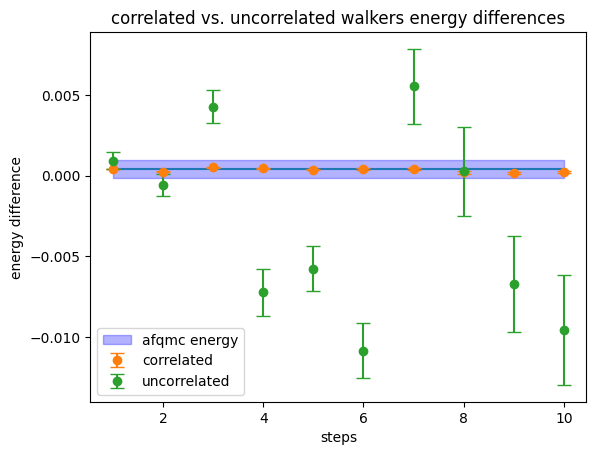

In [30]:
x_steps = np.linspace(1,10,100)
afqmc_en = np.array([afqmc_en_diff]*len(x_steps))
afqmc_lw = afqmc_en-afqmc_en_diff_err
afqmc_up = afqmc_en+afqmc_en_diff_err
plt.plot(x_steps,afqmc_en)
plt.fill_between(x_steps, afqmc_lw, afqmc_up, color='blue', alpha=0.3, label='afqmc energy')
plt.errorbar(steps+1,cwalker_en_diff,yerr=weight_cwalker_en_diff_err, fmt='o', capsize=5,label='correlated')
plt.errorbar(steps+1,walker_en_diff,yerr=weight_walker_en_diff_err, fmt='o', capsize=5,label='uncorrelated')
plt.xlabel('steps')
plt.ylabel('energy difference')
plt.title('correlated vs. uncorrelated walkers energy differences')
plt.legend()
plt.show()